# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Описание данных
- children — количество детей в семье
- days_employed — общий трудовой стаж в днях
- dob_years — возраст клиента в годах
- education — уровень образования клиента
- education_id — идентификатор уровня образования
- family_status — семейное положение
- family_status_id — идентификатор семейного положения
- gender — пол клиента
- income_type — тип занятости
- debt — имел ли задолженность по возврату кредитов
- total_income — ежемесячный доход
- purpose — цель получения кредита

## Загрузка данных и библиотек

In [73]:
import pandas as pd
pd.options.mode.chained_assignment = None

from pymystem3 import Mystem
from collections import Counter

In [2]:
df = pd.read_csv('/datasets/data.csv')

In [3]:
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Проблемы в данных:

- Отрицательные значения в столбце days_employed
- Аномальное значение 340266.072047 дней в столбце days_employed
- дубликаты в столбце education с значениями написанными в разных регистрах
- Причины описанные в столбце purpose повторяются в разной формулировке

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [5]:
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


Прежде чем приступать к анализу, нужно провести предобработку.

- Обработать отрицательные значения в столбце days_employed
- Обработать аномалии в days_employed
- Обработать дубликаты в столбце education с значениями написанными в разных регистрах
- Обработать пропуски в стобце days_employed и total_income. 
- Перевести колонку total_income в int.
- days_employed следует перевести из float в int

## Предобработка данных

### Обработка пропусков

#### days_employed

In [6]:
# число пропусков
df['days_employed'].isna().sum()

2174

In [8]:
# число записей с отрицательным days_employed
df[df['days_employed'] < 0]['days_employed'].count()

15906

3/4 значений в колонке days_employed отрицательные.

Проверю, что из себя представляют эти значения.\
Возможно, это действительные данные, у которых по ошибке появился знак минуса во время выгрузки.

In [9]:
negative_days_employed = df[df['days_employed'] < 0]['days_employed']

In [10]:
negative_days_employed.describe()

count    15906.000000
mean     -2353.015932
std       2304.243851
min     -18388.949901
25%      -3157.480084
50%      -1630.019381
75%       -756.371964
max        -24.141633
Name: days_employed, dtype: float64

In [11]:
df[df['days_employed'] > 0]['days_employed'].describe()

count      3445.000000
mean     365004.309916
std       21075.016396
min      328728.720605
25%      346639.413916
50%      365213.306266
75%      383246.444219
max      401755.400475
Name: days_employed, dtype: float64

Как видно выше, похожими на реальные выглядят только отрицательные значения в столбце days_employed (если поменять знак на плюс)

Положительные же значения составляют ~20% столбца. При этом минимальное значение равно 328728 дням, то есть почти 900 годам. Использовать эти данные для анализа нельзя.

In [12]:
df[df['days_employed'] == 0]['days_employed'].count()

0

В колонке days_employed нет значений равных нулю. 

Временно использую 0, чтобы заполнить некорректные положительные значения

In [13]:
df.loc[df['days_employed'] > 0, 'days_employed'] = 0

In [14]:
df[df['days_employed'] == 0]['days_employed'].count()

3445

In [15]:
df['days_employed'] = df['days_employed'].fillna(0)

In [16]:
df[df['days_employed'] == 0]['days_employed'].count()

5619

Положительные и отсутствующие значения приведены к нулю.

Сделал это для удобства при заполнении этих пропусков или их удалении.

In [17]:
correct_days_employed = df['days_employed'].abs()

In [18]:
correct_days_employed.describe()

count    21525.000000
mean      1738.772191
std       2234.171998
min          0.000000
25%          0.000000
50%        982.531720
75%       2518.168900
max      18388.949901
Name: days_employed, dtype: float64

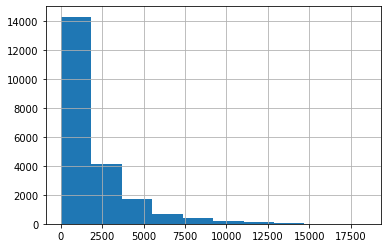

In [109]:
correct_days_employed.hist();

Ознакомившись с оставшимися данными, я делаю вывод, что желательнее использовать медиану, а не среднее из-за высокого стандартного отклонения, что свидетельствует о высоком разбросе данных. 

In [23]:
df.loc[df['days_employed'] < 0, 'days_employed'] = correct_days_employed

In [24]:
df.loc[df['days_employed'] == 0, 'days_employed'] = correct_days_employed.median()

In [25]:
df['days_employed'].describe()

count    21525.000000
mean      1995.257475
std       2070.210858
min         24.141633
25%        982.531720
50%        982.531720
75%       2518.168900
max      18388.949901
Name: days_employed, dtype: float64

Пропуски и ошибки в столбце days_employed были обработаны.
- У отрицательных значений, составлявших 3/4 колонки, изменен знак на положительный
- Аномально высокие значения (900 лет и более) и пропуски заменены на медиану

#### total_income

In [26]:
df['total_income'].isna().sum()

2174

In [27]:
df['total_income'].describe()

count    1.935100e+04
mean     1.674223e+05
std      1.029716e+05
min      2.066726e+04
25%      1.030532e+05
50%      1.450179e+05
75%      2.034351e+05
max      2.265604e+06
Name: total_income, dtype: float64

В колонке 2174 пропущенных значения.

Судя по информации из describe, данные выглядят правдоподобно, в них не наблюдается аномальных значений.\

Я решаю использовать медианные значения для заполнения пропусков в данных.\
Для каждой категории я использую медиану только по этой категории.\
Так, пропуски в зарплатах госслужащих будут заполнены будут заполнены медианной зарплатой госслужащих.

In [28]:
df['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
в декрете              1
студент                1
Name: income_type, dtype: int64

In [29]:
df.loc[df['income_type'] == "пенсионер", ['total_income']].describe()

,total_income
count,3443.000000
mean,137127.465690
std,80246.953231
min,20667.263793
25%,82881.443465
50%,118514.486412
75%,169700.433010
max,735103.270167


In [30]:
df.loc[df['income_type'] == "пенсионер", ['total_income']].isna().sum()

total_income    413
dtype: int64

Замечаю, что у пенсионеров достаточно разнообразные уровни дохода, следовательно менять уровень дохода на ноль всем пустым значениям будет неверно. Могу предположить, что в качестве дохода учитывается не только зарплата, но и пенсия, доход с инвестиций etc. 

In [31]:
def income_filler(df, income_type):
    income_group = df.loc[df['income_type'] == income_type, ['total_income']]
    median = income_group.median()
    print('Медианный доход категории', income_type, 'равен', int(median))
    
    income_group = income_group.fillna(median)
    df.loc[df['income_type'] == income_type, ['total_income']] = income_group
    print('Пропусков осталось:', int(df.loc[df['income_type'] == income_type, ['total_income']].isna().sum()))

In [32]:
income_types = ['пенсионер','сотрудник','компаньон','госслужащий']

In [33]:
for income_type in income_types:
    income_filler(df, income_type)

Медианный доход категории пенсионер равен 118514
Пропусков осталось: 0
Медианный доход категории сотрудник равен 142594
Пропусков осталось: 0
Медианный доход категории компаньон равен 172357
Пропусков осталось: 0
Медианный доход категории госслужащий равен 150447
Пропусков осталось: 0


In [34]:
df['total_income'].isna().sum()

1

После заполнения больших категорий остался еще один пропуск 

In [35]:
df.loc[df['total_income'].isna()]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
5936,0,982.53172,58,высшее,0,женат / замужем,0,M,предприниматель,0,NaN,покупка жилой недвижимости


Для простоты дальнейшей работы удалю это значение.

In [36]:
df = df.dropna().reset_index(drop = True)

In [37]:
df['total_income'].describe()

count    2.152400e+04
mean     1.652098e+05
std      9.801952e+04
min      2.066726e+04
25%      1.077960e+05
50%      1.425944e+05
75%      1.955452e+05
max      2.265604e+06
Name: total_income, dtype: float64

In [38]:
df.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

Пропуски в столбцах days_employed и total_income были заполнены медианными значениями. 

Для заполнения пропусков в total_income использовались медианные значения категории людей, к которой принадлежит человек, на основании столбца "income_type", то есть типа занятости. Так, например, пропуски в зарплате госслужащих заполнены медианной зарплатой всех госслужащих

### Типы данных

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21524 entries, 0 to 21523
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21524 non-null  int64  
 1   days_employed     21524 non-null  float64
 2   dob_years         21524 non-null  int64  
 3   education         21524 non-null  object 
 4   education_id      21524 non-null  int64  
 5   family_status     21524 non-null  object 
 6   family_status_id  21524 non-null  int64  
 7   gender            21524 non-null  object 
 8   income_type       21524 non-null  object 
 9   debt              21524 non-null  int64  
 10  total_income      21524 non-null  float64
 11  purpose           21524 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [40]:
df['days_employed'] = df['days_employed'].astype('int64')

In [41]:
df['days_employed'].head()

0    8437
1    4024
2    5623
3    4124
4     982
Name: days_employed, dtype: int64

In [42]:
df['total_income'] = df['total_income'].astype('int64')

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21524 entries, 0 to 21523
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21524 non-null  int64 
 1   days_employed     21524 non-null  int64 
 2   dob_years         21524 non-null  int64 
 3   education         21524 non-null  object
 4   education_id      21524 non-null  int64 
 5   family_status     21524 non-null  object
 6   family_status_id  21524 non-null  int64 
 7   gender            21524 non-null  object
 8   income_type       21524 non-null  object
 9   debt              21524 non-null  int64 
 10  total_income      21524 non-null  int64 
 11  purpose           21524 non-null  object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


Колонки days_employed и total_income приведены к типу int.

- тип days_employed заменен, потому что количество дней это целочисленное значение
- тип total_income заменен для простоты дальнейшей работы с данными и их лучшей наглядности.\
    Я предполагаю, что погрешности в несколько копеек не сыграют большой роли при анализе.

### Обработка дубликатов

In [44]:
df.duplicated().sum()

54

In [45]:
df.duplicated(keep='first').sum()

54

Метод duplicated обнуражил 54 дубликата.

Однако я помню, что в таблице есть дубликаты появившиеся из-за разного регистра. Сначала обработаю их и после этого повторю поиск

In [46]:
df['education'].value_counts()

среднее                13750
высшее                  4717
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

In [47]:
df['education'] = df['education'].str.lower()

In [48]:
df['education'].value_counts()

среднее                15233
высшее                  5259
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

Дубликаты в колонке education убраны, все значения приведены к нижнему регистру

In [49]:
df['family_status'].value_counts()

женат / замужем          12379
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

In [50]:
df['gender'].value_counts()

F      14236
M       7287
XNA        1
Name: gender, dtype: int64

In [51]:
df['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        1
в декрете              1
студент                1
Name: income_type, dtype: int64

In [52]:
df.duplicated().sum()

71

In [53]:
df = df.drop_duplicates().reset_index(drop=True)

Дубликаты в колонке education убраны. Возможно, что значения вносятся вручную, из-за чего появляется такая непоследовательность. 

После очистки дубликатов была найдено 71 дублирующаяся строка. Удаляю их.

### Лемматизация

In [54]:
m = Mystem() 

In [55]:
purposes = df['purpose'].value_counts()

In [56]:
purposes

свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           765
операции с недвижимостью                  675
покупка коммерческой недвижимости         661
операции с жильем                         652
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     650
покупка жилья                             646
жилье                                     646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          624
покупка недвижимости                      621
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                605
на покупку своего автомобиля              505
заняться высшим образованием      

In [57]:
purposes_list = list(purposes.index.values)

In [58]:
def lemma_counter(list):
    total_lemmas = []
    
    for line in list:
        lemmas = m.lemmatize(line) # получил список лемм из строки
        for lemma in lemmas:
            total_lemmas.append(lemma)
            
    return(Counter(total_lemmas)) 

In [59]:
lemmas = lemma_counter(purposes_list)

In [60]:
lemmas

Counter({'свадьба': 3,
         '\n': 38,
         'на': 4,
         ' ': 59,
         'проведение': 1,
         'сыграть': 1,
         'операция': 4,
         'с': 5,
         'недвижимость': 10,
         'покупка': 10,
         'коммерческий': 2,
         'жилье': 7,
         'для': 2,
         'сдача': 1,
         'семья': 1,
         'строительство': 3,
         'собственный': 1,
         'со': 1,
         'свой': 4,
         'жилой': 2,
         'ремонт': 1,
         'автомобиль': 9,
         'заниматься': 2,
         'высокий': 3,
         'образование': 9,
         'сделка': 2,
         'подержанный': 1,
         'подержать': 1,
         'приобретение': 1,
         'дополнительный': 2,
         'получение': 3,
         'профильный': 1})

In [61]:
lemmas_df = pd.DataFrame.from_dict(lemmas, orient='index').reset_index()

In [62]:
lemmas_df.head()

,index,0
0,свадьба,3
1,\n,38
2,на,4
3,,59
4,проведение,1


In [63]:
lemmas_df.set_axis(['lemma', 'count'], axis = 'columns', inplace = True)

In [64]:
lemmas_df.head()

,lemma,count
0,свадьба,3
1,\n,38
2,на,4
3,,59
4,проведение,1


In [65]:
lemmas_df.sort_values(by = 'count', ascending = False)

,lemma,count
3,,59
1,\n,38
8,недвижимость,10
9,покупка,10
21,автомобиль,9
24,образование,9
11,жилье,7
7,с,5
2,на,4
18,свой,4


Был получен список лемм с частотой их появления в уникальных значениях в колонке purpose. Благодаря этому я имею представление о том, на какие категории я буду делить данные по целям получения кредита:

- недвижимость или жилье
- автомобиль
- образование
- свадьба
- ремонт жилья

### Категоризация данных

#### Кагегоризация по количеству детей в семье

In [66]:
df.groupby('children').count()

,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
children,,,,,,,,,,,
-1,47,47,47,47,47,47,47,47,47,47,47
0,14090,14090,14090,14090,14090,14090,14090,14090,14090,14090,14090
1,4808,4808,4808,4808,4808,4808,4808,4808,4808,4808,4808
2,2052,2052,2052,2052,2052,2052,2052,2052,2052,2052,2052
3,330,330,330,330,330,330,330,330,330,330,330
4,41,41,41,41,41,41,41,41,41,41,41
5,9,9,9,9,9,9,9,9,9,9,9
20,76,76,76,76,76,76,76,76,76,76,76


Замечаю, что в данных есть артефакты:
- 47 строк с -1 ребенком
- 76 строк с 20 детьми

Аномальные значения занимают незначительную часть датафрейма, поэтому я считаю правильным не учитывать строки с этими значениями при анализе зависимости между наличием детей и возвратом кредита. 

Могу предположить, что -1 ребенок или означает отсутствие детей, или одного ребенка (с появившимся по ошибке при заполнении знаком минуса)
20 детей также могли появиться при ошибке при заполнении или обработке данных, предполагаю, что это 2 ребенка.

In [68]:
children_grouped = df[(df['children'] != -1) & (df['children'] != 20)]

In [69]:
children_grouped.groupby('children').count()

,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
children,,,,,,,,,,,
0,14090,14090,14090,14090,14090,14090,14090,14090,14090,14090,14090
1,4808,4808,4808,4808,4808,4808,4808,4808,4808,4808,4808
2,2052,2052,2052,2052,2052,2052,2052,2052,2052,2052,2052
3,330,330,330,330,330,330,330,330,330,330,330
4,41,41,41,41,41,41,41,41,41,41,41
5,9,9,9,9,9,9,9,9,9,9,9


Вижу, что 4 и 5 детей имеются только в 50 строках. Поэтому вместо создания отдельных категорий для них, заведу общую категорию для трех и более детей

In [70]:
def children_grouper(children):
    if children == 0:
        return "нет детей"
    if children == 1:
        return "один ребенок"
    if children == 2:
        return "два ребенка"
    else:
        return "три ребенка или больше"

In [74]:
children_grouped['children_group'] = children_grouped['children'].apply(children_grouper)

In [75]:
children_grouped.groupby('children_group').count()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
children_group,,,,,,,,,,,,
два ребенка,2052,2052,2052,2052,2052,2052,2052,2052,2052,2052,2052,2052
нет детей,14090,14090,14090,14090,14090,14090,14090,14090,14090,14090,14090,14090
один ребенок,4808,4808,4808,4808,4808,4808,4808,4808,4808,4808,4808,4808
три ребенка или больше,380,380,380,380,380,380,380,380,380,380,380,380


Данные разбиты по категориям основываясь на количестве детей в семье

#### Кагегоризация по семейному положению

In [76]:
df['family_status'].value_counts()

женат / замужем          12338
гражданский брак          4151
Не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64

Категории и так выглядят довольно большими, можно попробовать анализировать их. Также интересно изучить данные поделив их на три большие категории:
- женат / замужем
- гражданский брак       
- Не женат / не замужем (добавить к текущей категории людей в разводе и вдов/вдовцов)

In [77]:
df['family_status_alternative'] = df['family_status']

In [78]:
df.loc[df['family_status_alternative'] == 'в разводе', 
       'family_status_alternative'] = 'Не женат / не замужем' 

In [79]:
df.loc[df['family_status_alternative'] == 'вдовец / вдова', 
       'family_status_alternative'] = 'Не женат / не замужем'

In [80]:
df['family_status_alternative'].value_counts()

женат / замужем          12338
Не женат / не замужем     4964
гражданский брак          4151
Name: family_status_alternative, dtype: int64

Добавил отдельный столбец для анализа семейного положения по трем категориям

#### Кагегоризация по уровню дохода

In [81]:
df['total_income'].describe()

count    2.145300e+04
mean     1.653040e+05
std      9.816313e+04
min      2.066700e+04
25%      1.076200e+05
50%      1.425940e+05
75%      1.958180e+05
max      2.265604e+06
Name: total_income, dtype: float64

In [82]:
first_quantile_income = df['total_income'].quantile(0.25)

In [83]:
second_quantile_income = df['total_income'].quantile(0.5)

In [84]:
third_quantile_income = df['total_income'].quantile(0.75)

In [85]:
max_income = df['total_income'].max()

In [86]:
def income_classifier(income):
    if income < first_quantile_income:
        return('низкий доход')
    if income < second_quantile_income:
        return('средний доход')
    if income < third_quantile_income:
        return('высокий доход')
    if income <= max_income:
        return('очень высокий доход')

In [87]:
df['income_group'] = df['total_income'].apply(income_classifier)

In [88]:
df['income_group'].value_counts()

высокий доход          6316
очень высокий доход    5364
низкий доход           5363
средний доход          4410
Name: income_group, dtype: int64

Данные ежемесячного дохода поделены на 4 примерно равные категории

#### Кагегоризация по причине взять кредит

Вспоминаю, что в шаге лемматизации были выделены следующие категории причин взять кредит:

- недвижимость/жилье
- автомобиль
- образование
- свадьба
- ремонт

In [89]:
def purpose_classifier(purpose):
    lemmas = m.lemmatize(purpose)
    if 'недвижимость' in lemmas:
        return('Покупка недвижимости')
    if 'жилье' in lemmas:
        return('Покупка недвижимости')
    if 'автомобиль' in lemmas:
        return('Покупка автомобиля')
    if 'образование' in lemmas:
        return('Покупка образования')
    if 'свадьба' in lemmas:
        return('Проведение свадьбы')
    if 'ремонт' in lemmas:
        return('Проведение ремонта')
    else:
        return('Другое')

In [90]:
df['purpose_group'] = df['purpose'].apply(purpose_classifier)

In [91]:
df['purpose_group'].value_counts()

Покупка недвижимости    10810
Покупка автомобиля       4306
Покупка образования      4013
Проведение свадьбы       2324
Name: purpose_group, dtype: int64

**Вывод**

На основании поставленных задач, данные были разделены на категории:

- **children_group** по числу детей в семье


- **family_status** и **family_status_alternative** по семейному положению, где:
    - **family_status** учитывает такие категории как "в разводе" и "вдовец / вдова"
    - **family_status_alternative** вносит эти значения в более обширную категорию "Не женат / не замужем"
    
    
- **income_group** по уровню дохода. Для создания категорий использовались первый, второй и третий квантили. Все значения оказавшиеся выше третьего квантиля отнесены в отдельную категорию "очень высокий доход"


- **purpose_group** по причине взять кредит. Для категоризации использовались полученные в ходе предобработки данных леммы с наиболее часто повторяющимися словами в запросах клиентов:
    - Покупка недвижимости
    - Покупка автомобиля
    - Покупка образования
    - Проведение свадьбы
    - Проведение ремонта

## Ответы на вопросы исследования

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [92]:
debt_expired = df['debt'].sum() #количество должников

In [93]:
debt_total = df['debt'].count() # количество заемщиков

In [94]:
debt_ratio_total = debt_expired / debt_total #отношение должников ко всем заемщикам 

In [95]:
print('Процент должников среди всех заемщиков составляет: {:.2%}'.format(debt_ratio_total))

Процент должников среди всех заемщиков составляет: 8.12%


In [96]:
def ratio_calculator(df, index, columns, values):
    table_pivot = df.pivot_table(index=[index], columns = columns, values = values, aggfunc='count')
    table_pivot[0] = table_pivot[0] + table_pivot[1]
    table_pivot['ratio %'] = round(table_pivot[1] / table_pivot[0], 4) * 100
    table_pivot.columns = ['Всего заемщиков', 'Есть задолженность', 'Процент должников']
    table_pivot = table_pivot.sort_values(by = 'Процент должников')
    table_pivot.loc['Общие данные'] = [debt_total, debt_expired, round(debt_ratio_total, 4) * 100]
    
    return table_pivot

In [97]:
children_grouped_pivot = ratio_calculator(children_grouped, 'children_group', 'debt', 'gender')

In [98]:
children_grouped_pivot

,Всего заемщиков,Есть задолженность,Процент должников
children_group,,,
нет детей,14090.0,1063.0,7.54
три ребенка или больше,380.0,31.0,8.16
один ребенок,4808.0,444.0,9.23
два ребенка,2052.0,194.0,9.45
Общие данные,21453.0,1741.0,8.12


Судя по полученным данным, клиенты без детей имеют меньше всех задолженностей с отношением кредитов с заолженностью к кредитам без задолженности в 7.54%, что меньше среднего соотношения по всем клиентам, равным 8.12%

Семьи в которых есть хотя бы один ребенок уже имеют более высокий процент задолженностей:

- 9.23% у клиентов с одним ребенком
- 9.45% у клиентов с двумя детьми
- 8.16% у клиентов с тремя и более детьми

Также важно заметить,что выборка клиентов с тремя и более детьми была мала, возможно стоит не спешить с выводами по этой категории, основываясь только на имеющихся данных

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [99]:
df['family_status'].value_counts()

женат / замужем          12338
гражданский брак          4151
Не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64

In [100]:
df_family_status_pivot = ratio_calculator(df, 'family_status', 'debt', 'gender')

In [101]:
df_family_status_pivot

,Всего заемщиков,Есть задолженность,Процент должников
family_status,,,
вдовец / вдова,959.0,63.0,6.57
в разводе,1195.0,85.0,7.11
женат / замужем,12338.0,931.0,7.55
гражданский брак,4151.0,388.0,9.35
Не женат / не замужем,2810.0,274.0,9.75
Общие данные,21453.0,1741.0,8.12


**Вывод**

Судя по получившимся данным, решение сделать две разные категоризации данных по семейному состоянию было верным. Наблюдается следующая зависимость между семейным положением и возвратом кредита в срок:

- Реже всех задолженности по возврату кредита бывают у людей в разводе и вдов/вдовцов с 6.57% и 7.11% соответственно.

- Люди из категории "женат / замужем" также имеют более низкий риск иметь задолженность, в сравнении с общей популяцией по датасету - 7.55% 

- Люди состоящие в гражанском браке и не женатые / не замужем чаще имеют задолженности с 9.35% и 9.75% соответственно

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [102]:
df['income_group'].value_counts()

высокий доход          6316
очень высокий доход    5364
низкий доход           5363
средний доход          4410
Name: income_group, dtype: int64

In [103]:
df['total_income'].describe()

count    2.145300e+04
mean     1.653040e+05
std      9.816313e+04
min      2.066700e+04
25%      1.076200e+05
50%      1.425940e+05
75%      1.958180e+05
max      2.265604e+06
Name: total_income, dtype: float64

In [104]:
df_income_group_pivot = ratio_calculator(df, 'income_group', 'debt', 'gender')

In [105]:
df_income_group_pivot

,Всего заемщиков,Есть задолженность,Процент должников
income_group,,,
очень высокий доход,5364.0,383.0,7.14
низкий доход,5363.0,427.0,7.96
высокий доход,6316.0,546.0,8.64
средний доход,4410.0,385.0,8.73
Общие данные,21453.0,1741.0,8.12


**Вывод**

- Низкий доход: 107 623 рублей и менее
- Средний: больше чем низкий уровень, но не больше 145 017 рублей в месяц
- Высокий: не более 195 813 рублей в месяц
- Очень высокий: более 195 813 рублей

Реже всех имеют задолженность клиенты с очень высоким доходом от 195 813 рублей в год - 7.14%. 

Что любопытно, так это то, что люди с высоким и средним доходом чаще имеют задолженности чаще, чем люди с низким доходом. 

- Как разные цели кредита влияют на его возврат в срок?

In [106]:
df['purpose_group'].value_counts()

Покупка недвижимости    10810
Покупка автомобиля       4306
Покупка образования      4013
Проведение свадьбы       2324
Name: purpose_group, dtype: int64

In [107]:
df_purpose_group_pivot = ratio_calculator(df, 'purpose_group', 'debt', 'gender')

In [108]:
df_purpose_group_pivot

,Всего заемщиков,Есть задолженность,Процент должников
purpose_group,,,
Покупка недвижимости,10810.0,782.0,7.23
Проведение свадьбы,2324.0,186.0,8.00
Покупка образования,4013.0,370.0,9.22
Покупка автомобиля,4306.0,403.0,9.36
Общие данные,21453.0,1741.0,8.12


**Вывод**

Взаимосвязь между причиной взять кредит и задолженностью также наблюдается. 

Реже всех имеют задолженности люди, берущие кредит на покупку недвижимости - 7.23%

Чаще всех задолженность имеют клиенты, покупающие в кредит образование или автомобиль.

## Шаг 4. Общий вывод

На возврат кредита влияют такие факторы как наличие детей, семейное положение, уровень доходов и цель кредита. 

Основные находки:

- Клиенты без детей чаще возвращают кредит в срок
- Люди состоящие в браке сейчас или состоявшие ранее (сейчас в разводе или вдовы/вдовцы) чаще возвращают кредит в срок
- Люди с высоким доходом (от 195 813 рублей в месяц) чаще всех возвращают кредит в срок. Чаще всех имеют задолженности люди со средним и высоким доходом (от 107 623 рублей до 195 813 рублей)
- Люди берущие деньги на покупку недвижимости чаще возвращают кредит в срок, в то время как покупка автомобиля и образования являются более рискованными категориями. 